In [1]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

Objetivo: segmentar os 3 loops de 6 frases de cada gravação

Cada loop está separado por:
Três piscadas intencionais

Que devem gerar picos de voltagem visíveis, especialmente em canais frontais como Fp1 e Fp2

1. Carregar todos os arquivos .pkl da pasta first_dataset_interpolated_clean
2. Para cada DataFrame:
- Analisar o canal Fp1 ou Fp2
- Usar scipy.signal.find_peaks para localizar as piscadas
- Dividir o DataFrame em 3 segmentos com base nesses picos
3. Usar find_peaks()
4. Cortar o DataFrame em 3 partes com base nos picos detectados
5. Armazenar os loops (opcional)

In [7]:
data_dir = Path("../raw_data/first_dataset_trimmed_clean")
pkl_files = sorted(data_dir.glob("*.pkl"))

dfs = [pd.read_pickle(f) for f in pkl_files]

In [8]:
dfs

[       sample_index           Fp1           Fp2            C3            C4  \
 0             216.0  19037.003104  16336.152415  46621.089771  27915.786554   
 1             218.0  19004.458964  16306.804574  46602.761340  27896.005260   
 2             220.0  18990.109144  16291.024243  46594.111215  27878.302679   
 3             222.0  19045.519119  16345.048409  46624.621347  27917.708804   
 4             224.0  18981.704889  16279.960129  46606.650544  27880.783722   
 ...             ...           ...           ...           ...           ...   
 16324          96.0  20505.199791  16852.835340  47367.146297  28757.665009   
 16325          98.0  20489.911197  16836.272697  47360.798402  28749.059588   
 16326         100.0  20468.878206  16815.038540  47347.923797  28730.328826   
 16327         102.0  20535.039369  16883.010195  47384.334789  28784.017716   
 16328         104.0  20470.129904  16813.876249  47350.136620  28729.144183   
 
                  T3           T4     

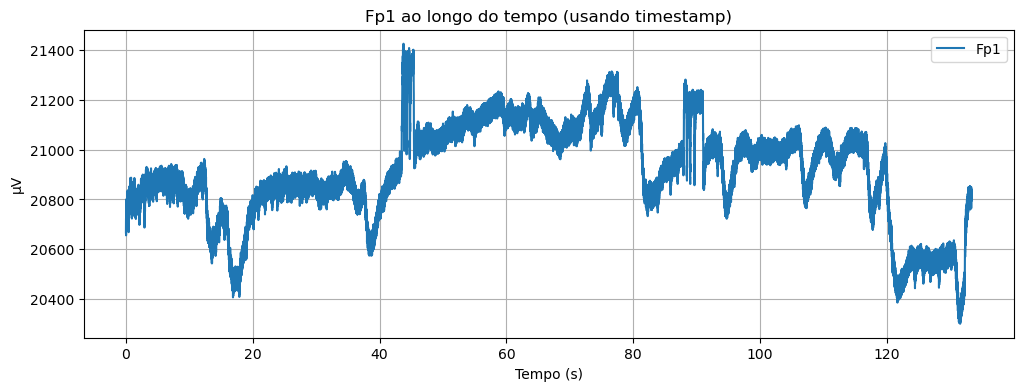

In [14]:
# Seleciona o penúltimo DataFrame
df = dfs[18]

# Calcula tempo relativo em segundos
df["time_sec"] = df["timestamp"] - df["timestamp"].iloc[0]

# Plot do canal Fp1
plt.figure(figsize=(12, 4))
plt.plot(df["time_sec"], df["Fp1"], label="Fp1")
plt.title("Fp1 ao longo do tempo (usando timestamp)")
plt.xlabel("Tempo (s)")
plt.ylabel("µV")
plt.grid(True)
plt.legend()
plt.show()


In [15]:
nan_counts = df.isna().sum()
print("NaNs por coluna:")
print(nan_counts[nan_counts > 0])

NaNs por coluna:
Series([], dtype: int64)


In [16]:
zero_counts = (df == 0).sum()
print("Zeros por coluna:")
print(zero_counts[zero_counts > 0])

Zeros por coluna:
sample_index      130
marker          16671
time_sec            1
dtype: int64


In [17]:
def plot_channel(df, channel="Fp1", title=None):
    plt.figure(figsize=(12, 4))
    plt.plot(df[channel], label=channel)
    plt.title(title or f"EEG Signal - {channel}")
    plt.xlabel("Amostras")
    plt.ylabel("µV")
    plt.grid(True)
    plt.legend()
    plt.show()

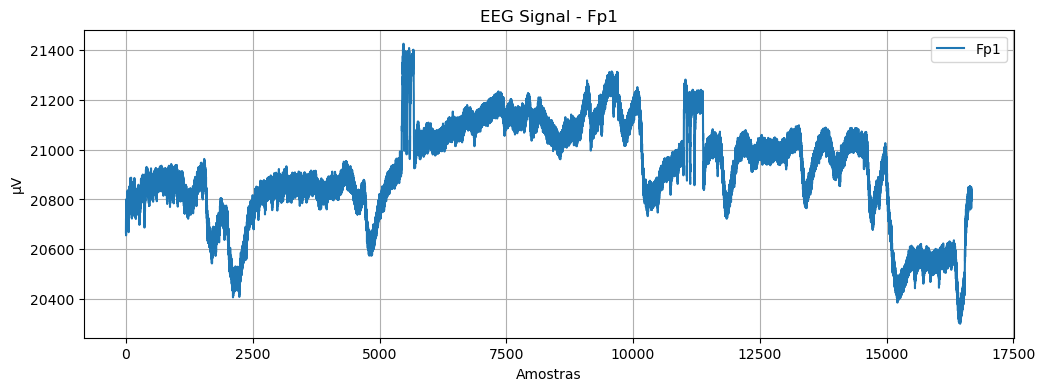

In [18]:
plot_channel(df, "Fp1")

In [19]:
def plot_channel_zoom(df, channel="Fp1", start=0, end=1000):
    plt.figure(figsize=(12, 4))
    plt.plot(df[channel].iloc[start:end], label=f"{channel} [{start}:{end}]")
    plt.title(f"{channel} (Zoom de {start} a {end})")
    plt.xlabel("Amostras")
    plt.ylabel("µV")
    plt.grid(True)
    plt.legend()
    plt.show()

In [20]:
def summarize_channel(df, channel="Fp1"):
    stats = df[channel].describe()
    print(f"📊 Estatísticas para {channel}:\n")
    print(stats)
    return stats

In [21]:
stats = summarize_channel(df, "Fp1")

📊 Estatísticas para Fp1:

count    16671.000000
mean     20915.359223
std        199.306244
min      20300.234294
25%      20809.809364
50%      20924.585572
75%      21064.731010
max      21426.583401
Name: Fp1, dtype: float64


In [27]:
def plot_with_peaks_in_timestamp_windows(df, channel="Fp1", windows=[(40, 60), (80, 100)],
                                         height=None, distance=None, prominence=None):
    """
    Plota o sinal completo e destaca os picos detectados em janelas específicas de tempo (usando timestamp).

    Parâmetros:
    - df: DataFrame com EEG
    - channel: nome do canal (ex: "Fp1")
    - windows: lista de tuplas (start_time, end_time) em segundos (relativos ao início)
    - height, distance, prominence: kwargs para find_peaks
    """

    # Calcula tempo relativo (segundos desde o início da gravação)
    df = df.copy()
    df["time_sec"] = df["timestamp"] - df["timestamp"].iloc[0]

    all_peaks = []

    for start_sec, end_sec in windows:
        mask = (df["time_sec"] >= start_sec) & (df["time_sec"] <= end_sec)
        signal_window = df.loc[mask, channel]

        # Índices locais no recorte
        peaks, _ = find_peaks(signal_window, height=height, distance=distance, prominence=prominence)

        # Converte para índices globais no DataFrame original
        peaks_adjusted = signal_window.index[peaks]
        all_peaks.extend(peaks_adjusted)

    # Plot
    plt.figure(figsize=(12, 4))
    plt.plot(df["time_sec"], df[channel], label=channel)
    plt.plot(df["time_sec"].iloc[all_peaks], df[channel].iloc[all_peaks], "rx", label="Detected Peaks")
    plt.title(f"{channel} com picos detectados nas janelas {windows}")
    plt.xlabel("Tempo (s)")
    plt.ylabel("µV")
    plt.grid(True)
    plt.legend()
    plt.show()

    print(f"🔎 {len(all_peaks)} picos detectados no canal {channel}")
    return all_peaks

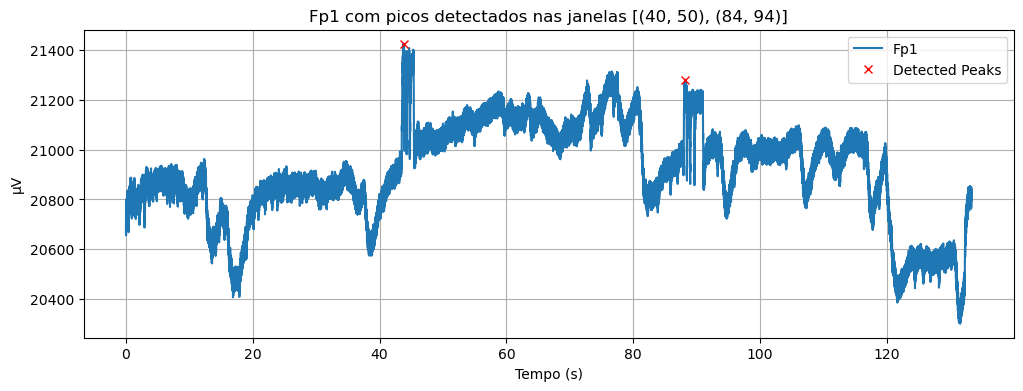

🔎 2 picos detectados no canal Fp1


[5473, 11033]

In [29]:
height = stats.mean()

plot_with_peaks_in_timestamp_windows(
    df,
    channel="Fp1",
    windows=[(40, 50), (84, 94)],
    height=height,
    distance=1000
)


🧠 Bloco 1
📊 Estatísticas para Fp1:

count    16329.000000
mean     19783.297876
std        379.104876
min      18933.760397
25%      19459.339316
50%      19823.516288
75%      20093.994748
max      20581.486294
Name: Fp1, dtype: float64


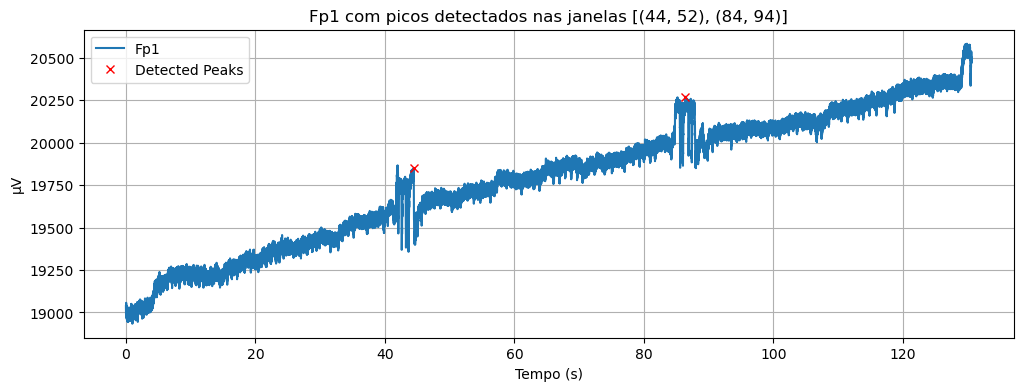

🔎 2 picos detectados no canal Fp1

🧠 Bloco 2
📊 Estatísticas para Fp1:

count    16619.000000
mean     21245.692365
std        315.472754
min      20425.471118
25%      21043.921536
50%      21269.115361
75%      21505.339772
max      21885.576473
Name: Fp1, dtype: float64


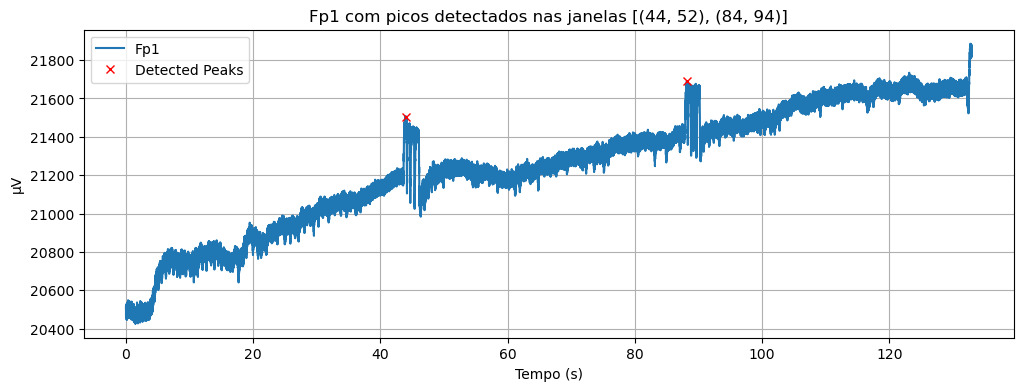

🔎 2 picos detectados no canal Fp1

🧠 Bloco 3
📊 Estatísticas para Fp1:

count    17013.000000
mean     21706.339321
std        355.100071
min      20914.348473
25%      21467.800017
50%      21631.414787
75%      21984.393535
max      22699.805820
Name: Fp1, dtype: float64


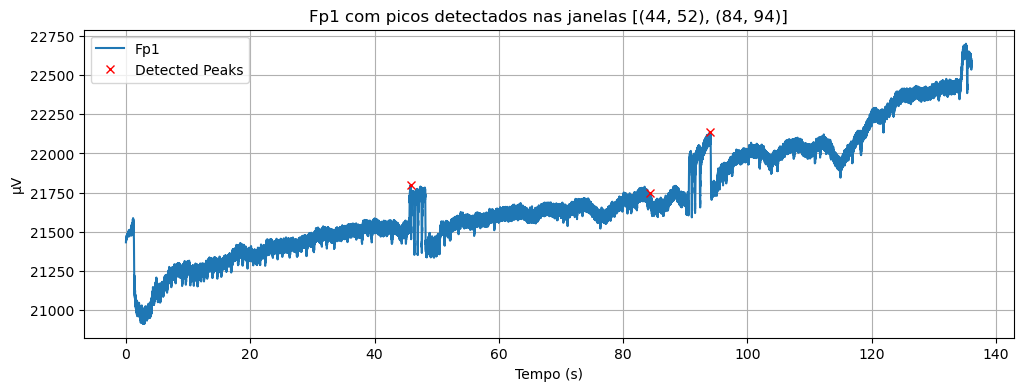

🔎 3 picos detectados no canal Fp1

🧠 Bloco 4
📊 Estatísticas para Fp1:

count    16832.000000
mean     22738.784239
std        160.371630
min      22318.283894
25%      22649.983782
50%      22725.074467
75%      22790.548315
max      23310.209609
Name: Fp1, dtype: float64


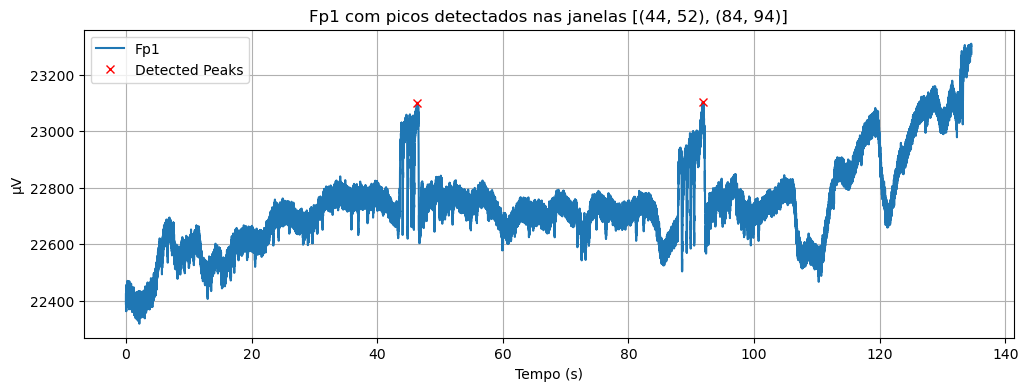

🔎 2 picos detectados no canal Fp1

🧠 Bloco 5
📊 Estatísticas para Fp1:

count    16904.000000
mean     21110.821963
std        241.790093
min      20643.959420
25%      20964.215215
50%      21062.238790
75%      21176.428265
max      22220.584419
Name: Fp1, dtype: float64


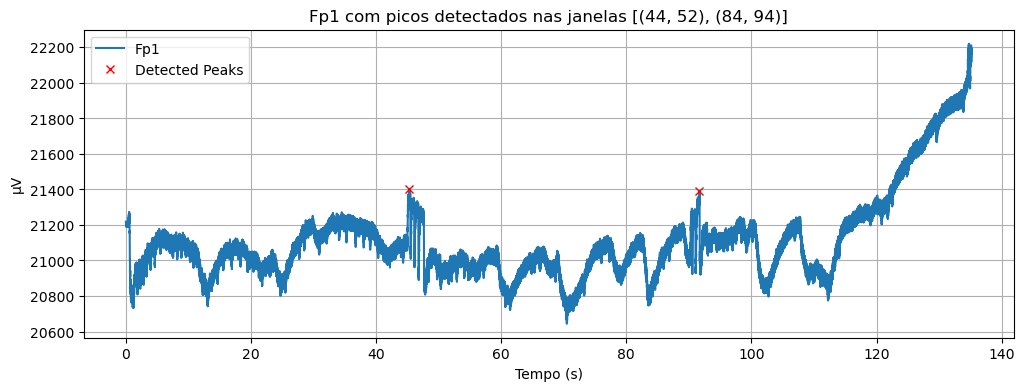

🔎 2 picos detectados no canal Fp1

🧠 Bloco 6
📊 Estatísticas para Fp1:

count    17015.000000
mean     23438.376921
std        342.822542
min      22653.515357
25%      23221.551415
50%      23446.443492
75%      23694.380217
max      24160.000582
Name: Fp1, dtype: float64


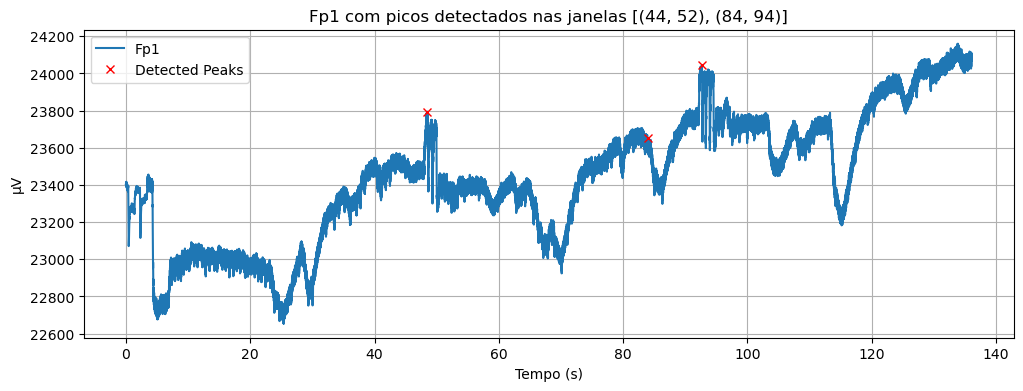

🔎 3 picos detectados no canal Fp1

🧠 Bloco 7
📊 Estatísticas para Fp1:

count    16768.000000
mean     23569.879162
std        219.518824
min      23092.011880
25%      23392.234923
50%      23517.052652
75%      23724.370670
max      24288.277243
Name: Fp1, dtype: float64


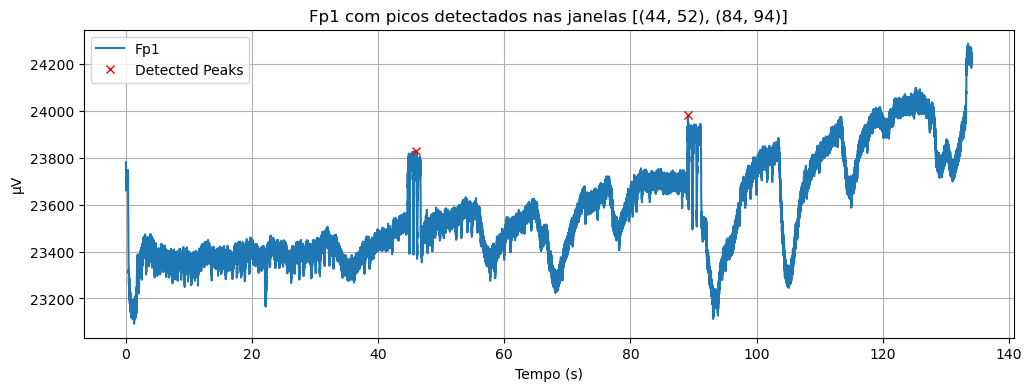

🔎 2 picos detectados no canal Fp1

🧠 Bloco 8
📊 Estatísticas para Fp1:

count    16622.000000
mean     23064.239035
std        606.602440
min      21769.883844
25%      22586.158375
50%      22878.217444
75%      23747.102394
max      24087.737392
Name: Fp1, dtype: float64


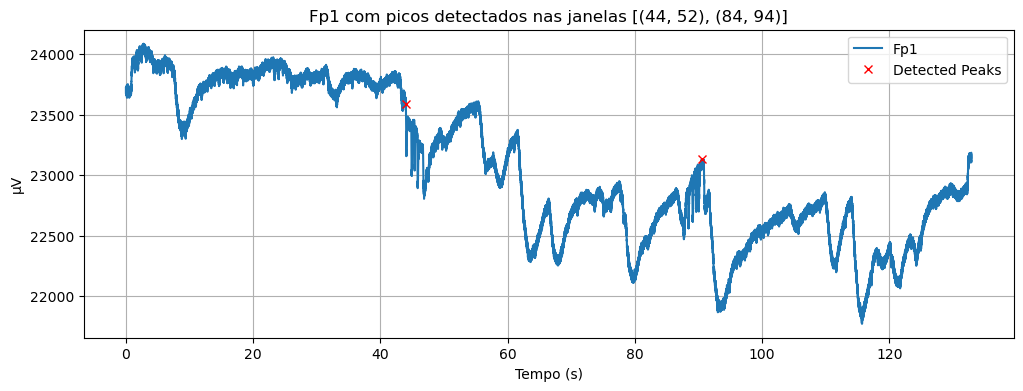

🔎 2 picos detectados no canal Fp1

🧠 Bloco 9
📊 Estatísticas para Fp1:

count    16627.000000
mean     23361.368067
std        707.752241
min      21430.070273
25%      22793.202584
50%      23643.608230
75%      23886.974023
max      24454.618925
Name: Fp1, dtype: float64


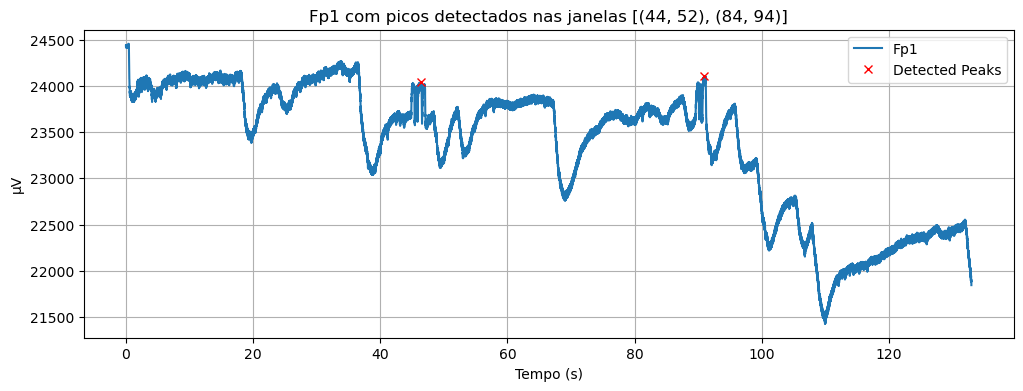

🔎 2 picos detectados no canal Fp1

🧠 Bloco 10
📊 Estatísticas para Fp1:

count    16778.000000
mean     23510.295192
std        374.993545
min      22362.965031
25%      23214.566495
50%      23517.533215
75%      23820.181423
max      24156.960744
Name: Fp1, dtype: float64


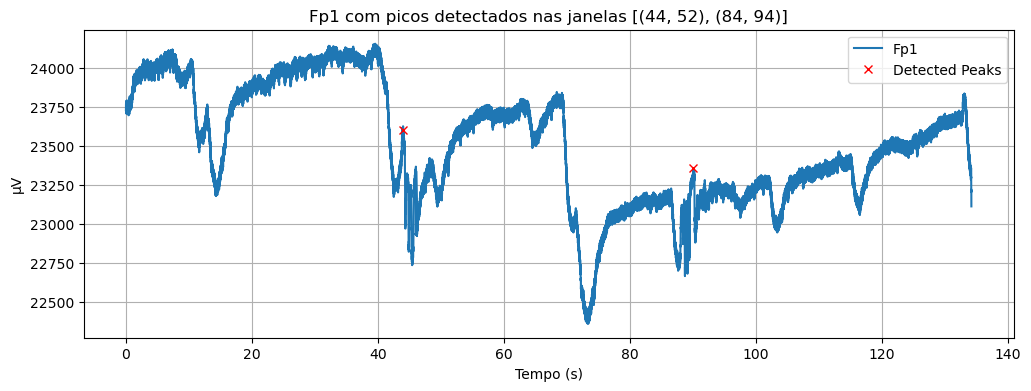

🔎 2 picos detectados no canal Fp1

🧠 Bloco 11
📊 Estatísticas para Fp1:

count    16731.000000
mean     23362.727766
std        204.799300
min      23008.572818
25%      23174.188068
50%      23337.679903
75%      23514.381619
max      23875.775799
Name: Fp1, dtype: float64


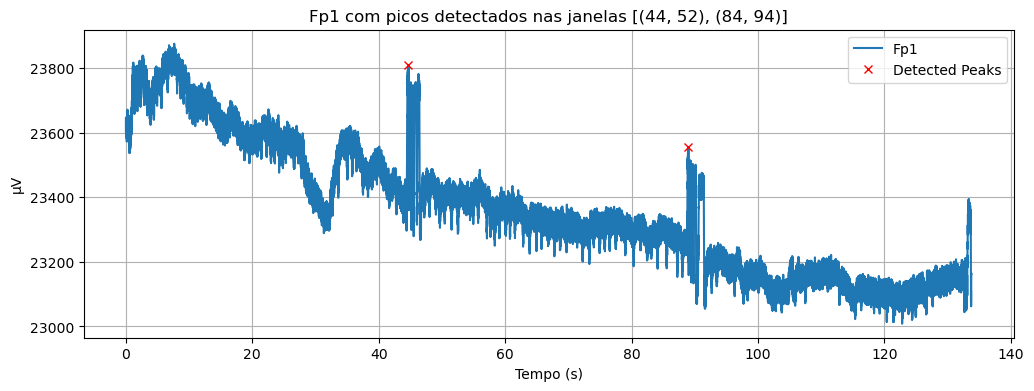

🔎 2 picos detectados no canal Fp1

🧠 Bloco 12
📊 Estatísticas para Fp1:

count    16580.000000
mean     22559.194408
std        166.779914
min      21770.979079
25%      22497.053146
50%      22578.145275
75%      22679.063401
max      22988.322137
Name: Fp1, dtype: float64


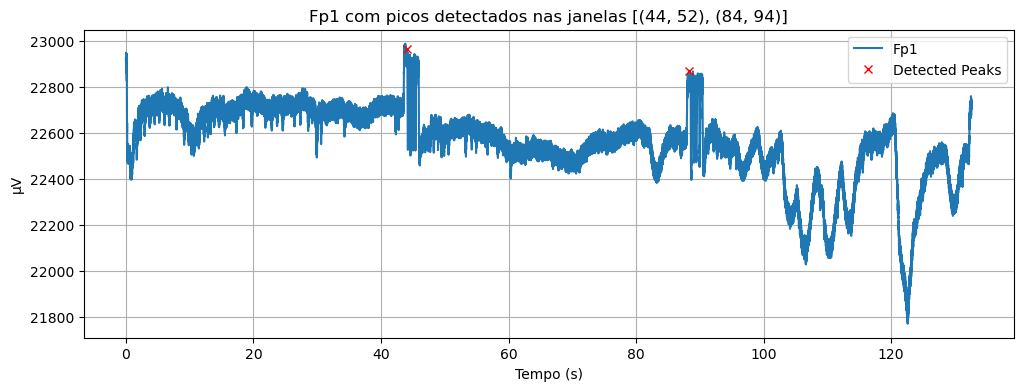

🔎 2 picos detectados no canal Fp1

🧠 Bloco 13
📊 Estatísticas para Fp1:

count    16906.000000
mean     22068.421829
std         94.195683
min      21777.259919
25%      22011.668251
50%      22057.550795
75%      22106.853155
max      22660.779674
Name: Fp1, dtype: float64


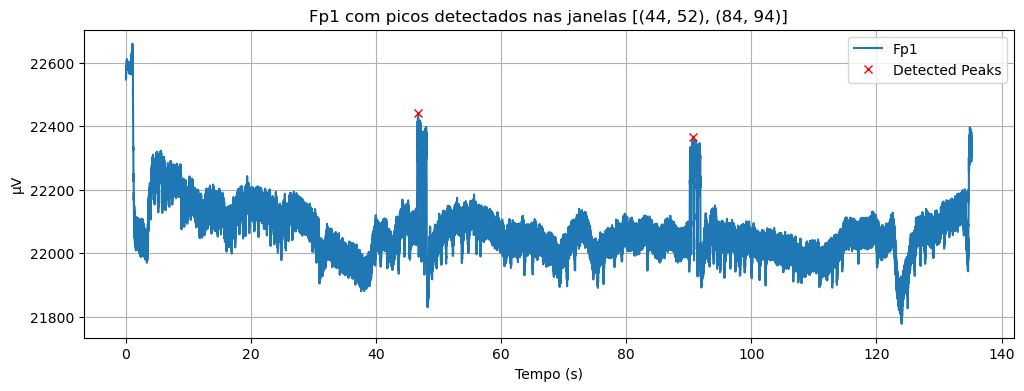

🔎 2 picos detectados no canal Fp1

🧠 Bloco 14
📊 Estatísticas para Fp1:

count    16646.000000
mean     22030.884624
std        193.363936
min      21302.553571
25%      21968.613204
50%      22092.419516
75%      22152.070734
max      22443.364256
Name: Fp1, dtype: float64


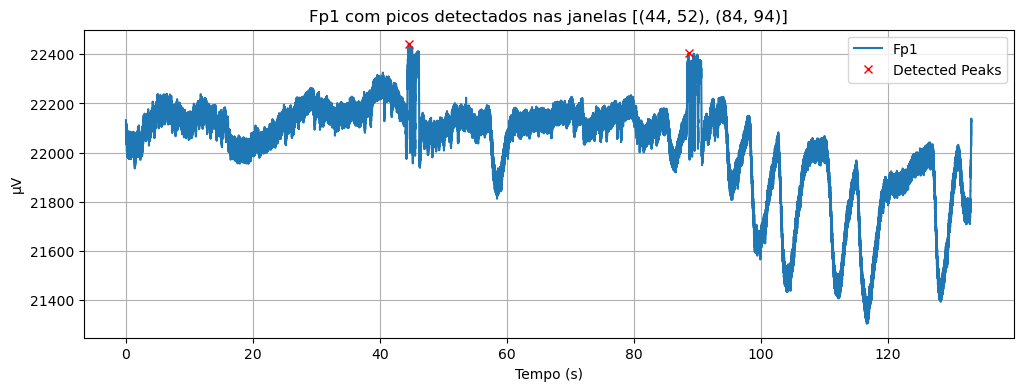

🔎 2 picos detectados no canal Fp1

🧠 Bloco 15
📊 Estatísticas para Fp1:

count    16632.000000
mean     22445.706472
std        158.065903
min      21916.310122
25%      22343.044039
50%      22448.371047
75%      22569.372215
max      22878.105685
Name: Fp1, dtype: float64


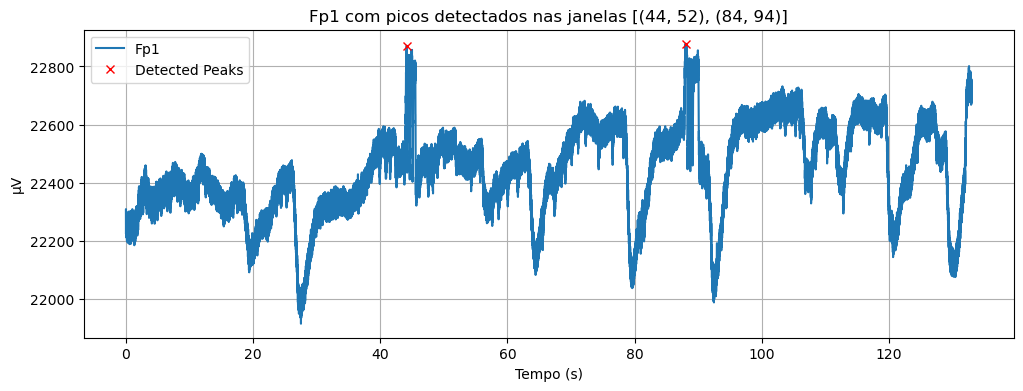

🔎 2 picos detectados no canal Fp1

🧠 Bloco 16
📊 Estatísticas para Fp1:

count    16663.000000
mean     22075.812638
std        364.419168
min      21060.752399
25%      21832.915763
50%      22138.687627
75%      22386.892574
max      22817.800679
Name: Fp1, dtype: float64


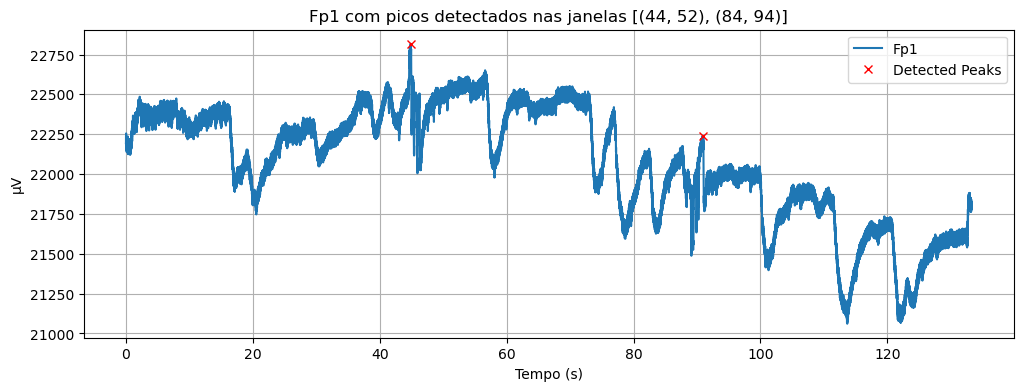

🔎 2 picos detectados no canal Fp1

🧠 Bloco 17
📊 Estatísticas para Fp1:

count    16562.000000
mean     21529.537592
std        219.090045
min      20741.435378
25%      21459.200184
50%      21575.513074
75%      21651.553709
max      22088.485609
Name: Fp1, dtype: float64


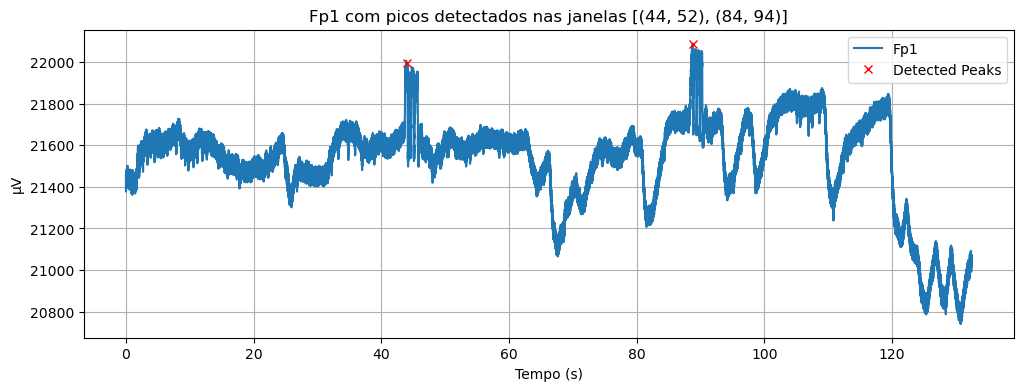

🔎 2 picos detectados no canal Fp1

🧠 Bloco 18
📊 Estatísticas para Fp1:

count    16777.000000
mean     21145.669495
std        203.003962
min      20444.425397
25%      21037.573640
50%      21192.515933
75%      21295.445716
max      21693.262064
Name: Fp1, dtype: float64


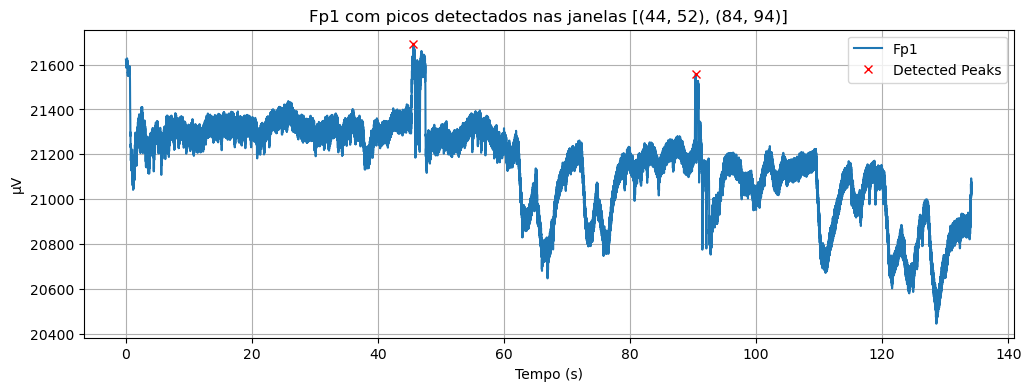

🔎 2 picos detectados no canal Fp1

🧠 Bloco 19
📊 Estatísticas para Fp1:

count    16671.000000
mean     20915.359223
std        199.306244
min      20300.234294
25%      20809.809364
50%      20924.585572
75%      21064.731010
max      21426.583401
Name: Fp1, dtype: float64


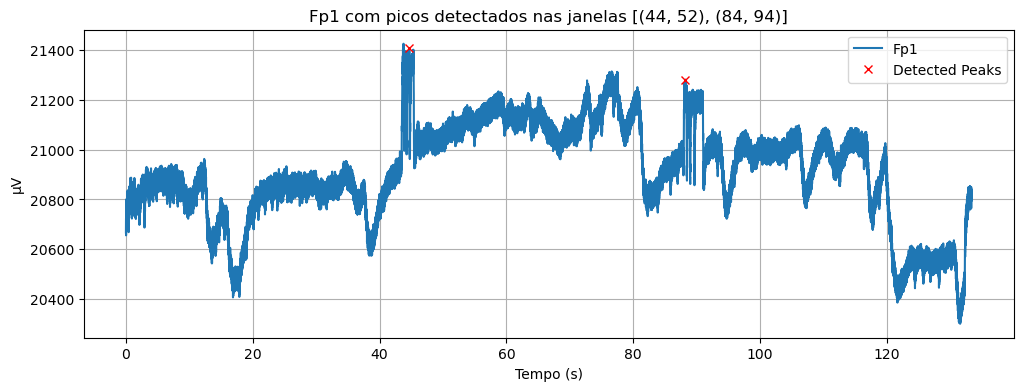

🔎 2 picos detectados no canal Fp1

🧠 Bloco 20
📊 Estatísticas para Fp1:

count    16565.000000
mean     20840.201880
std        428.424312
min      19607.978416
25%      20493.912160
50%      20886.498199
75%      21233.397273
max      21459.284003
Name: Fp1, dtype: float64


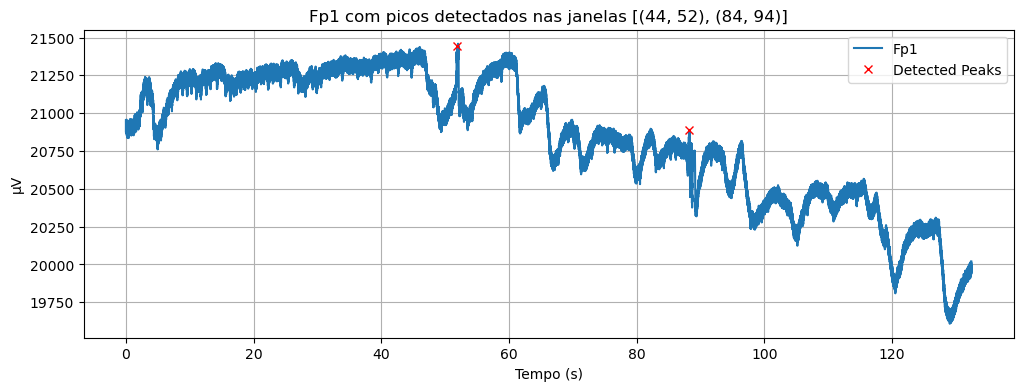

🔎 2 picos detectados no canal Fp1


In [41]:
# Plotar os 20 blocos e destacar os picos detectados
for i, df in enumerate(dfs):  # ou DFs, como você chamou
    print(f"\n🧠 Bloco {i+1}")
    stats = summarize_channel(df, "Fp1")
    height = stats.mean()

    plot_with_peaks_in_timestamp_windows(
        df,
        channel="Fp1",
        windows=[(44, 52), (84, 94)],  # suas janelas padrão
        height=height,
        distance=1000
    )


In [58]:
def split_loops_by_blinks(df, channel="Fp1", windows=[(44, 52), (84, 94)],
                          distance=None, prominence=None):
    """
    Divide um bloco de EEG em 3 loops com base em piscadas detectadas em janelas específicas.
    Usa a média do canal como altura mínima adaptativa.
    """
    signal_stats = df[channel].describe()
    adaptive_height = signal_stats["mean"]

    peaks_global = []

    for start_sec, end_sec in windows:
        mask = (df["time_sec"] >= start_sec) & (df["time_sec"] <= end_sec)
        signal = df.loc[mask, channel]
        if signal.empty:
            continue

        peaks, props = find_peaks(
            signal,
            height=adaptive_height,
            distance=distance,
            prominence=prominence
        )

        if len(peaks) == 0:
            continue

        # Acessar a 'height' retornada porque foi explicitamente passada
        main_peak = signal.index[props["peak_heights"].argmax()]
        peaks_global.append(main_peak)

    if len(peaks_global) != 2:
        print("⚠️ Não foi possível identificar duas piscadas confiáveis.")
        return None

    cut1, cut2 = peaks_global
    loop1 = df.iloc[:cut1].reset_index(drop=True)
    loop2 = df.iloc[cut1:cut2].reset_index(drop=True)
    loop3 = df.iloc[cut2:].reset_index(drop=True)

    return {"loop1": loop1, "loop2": loop2, "loop3": loop3}


In [74]:
df = dfs[18]

loops = split_loops_by_blinks(df, channel="Fp1", distance=1000)

if loops:
    for name, loop in loops.items():
        print(f"{name}: {len(loop)} linhas | {loop['time_sec'].iloc[-1]:.2f} s")


loop1: 5503 linhas | 44.00 s
loop2: 5002 linhas | 83.99 s
loop3: 6166 linhas | 133.30 s


In [75]:
def plot_loops(loops, channel="Fp1"):
    fig, axs = plt.subplots(3, 1, figsize=(14, 8), sharex=False, sharey=True)

    for i, name in enumerate(["loop1", "loop2", "loop3"]):
        loop = loops[name]
        axs[i].plot(loop["time_sec"], loop[channel])
        axs[i].set_title(f"{name} — {len(loop)} linhas | {loop['time_sec'].iloc[-1]:.2f} s")
        axs[i].set_ylabel("µV")
        axs[i].grid(True)

    axs[2].set_xlabel("Tempo (s)")
    plt.tight_layout()
    plt.suptitle(f"Sinal do canal {channel} nos 3 loops", fontsize=16, y=1.02)
    plt.show()

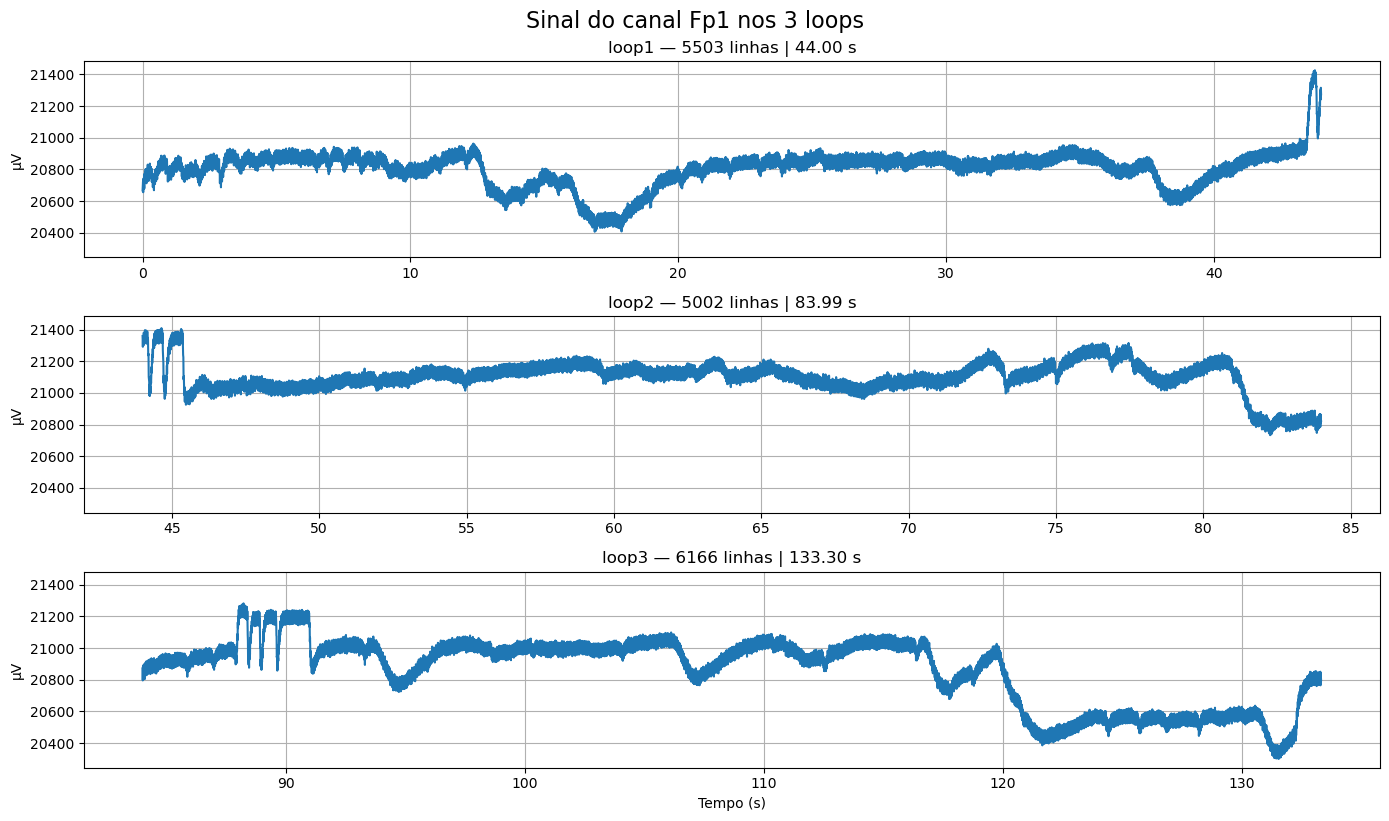

In [76]:
plot_loops(loops, channel="Fp1")